# 3. Creating custom components in Haystack


On this notebook, we will work with custome components done in Haystack. 

First of all, like previous notebooks, we load our .env file where we have some internal variables we will use to run certain functions.

In [1]:
import sys

sys.path.append("..")

In [2]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

Let's import the main dependencies used 

In [3]:
import requests

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument

## Custom Component Requirements



We have been using some ready-components before. As we can tell, components tipically have inputs and ouputs and run certain functions when called. We can tell then what constitues a component:
* Has inputs and ouputs.
* It is a class with the @component decorator.
* Has a run() method with @component.output_types decorator.
* Returns a dictionary.

Let's create a very simple component.

#### Build a Custom Component

Our basic component has the needed decorators, requires a user_name string input and returns a dictionary.

In [4]:
@component
class Greeter:

    @component.output_types(greeting=str)
    def run(self, user_name: str):
        return {"greeting": f"Hello {user_name}"}

Let's run the component and confirm it runs smoothly :

In [5]:
greeter = Greeter()

greeter.run(user_name="David")

{'greeting': 'Hello David'}

#### Creating our own Generator component

As we have in our own haystack library file, we want to have our own custom Generator component that comes from a personalized use of the original OpenAIGenerator().
You may start seeing now in these notebook the next component where we automatically call phi-3-mini-4k as our generator : 

In [11]:
import haystack_lib

phi_generator = haystack_lib.MiniPHILLM()

#### Creating a dialogue pipeline with custom components :

Let's create a pipeline that will use some of our newly created components.

We will use our **greeter** component to generate a simple line that we will add into a **template** used in the **prompt builder**. Then, we will pass this prompt into our new **phi-3-mini-4k generator**.

In [16]:
from haystack.utils import Secret

greeter = Greeter()
template = """ You will be given the beginning of a dialogue. 
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script: 
"""
prompt = PromptBuilder(template=template)
phi_generator = haystack_lib.MiniPHILLM()

PromptBuilder has 1 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


Now we will create our dialogue builder. We have to also add the created components and connect them. 

This time, we will need to specify certain connections : Our greeter will output a variable call a greeting, while the prompt builder is expecting a "dialogue" variable in its template. We need to point out that these will be connected.

In [17]:
dialogue_builder = Pipeline()
dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt)
dialogue_builder.add_component("llm", phi_generator)

dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: PromptBuilder
  - llm: MiniPHILLM
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.prompt (str)

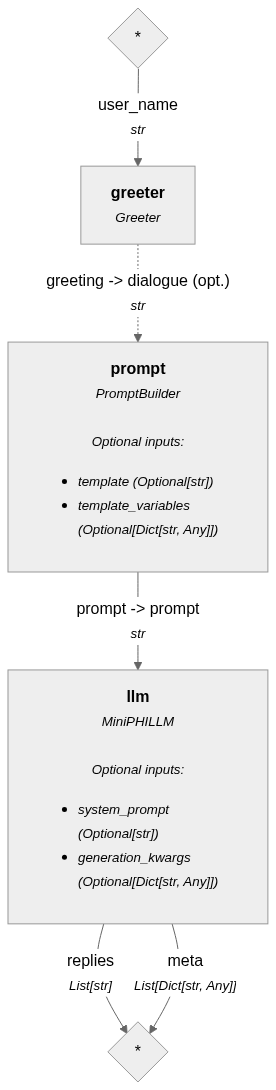

In [18]:
dialogue_builder.show()

We can see that the stream of data looks fine, so we are now ready to run the pipeline :

In [19]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "David"}})

print(dialogue["llm"]["replies"][0])

 Title: A Twist in Time

Characters:
- John (45) - A retired professor, living alone and missing his college friends.
- David (28) - An ambitious young man who shares a mysterious connection with John's past.

(Scene begins at John's cozy living room where he is sitting in an old armchair, reading a newspaper.)

John: (Sighs deeply and speaks to himself) Hello David...

(A sudden knock on the door startles him.)

John: (Puts down the newspaper and walks towards the door) Who could that be at this hour?

(Opens the door to reveal a young man, David, holding out his hand for an introduction.)

David: Hi there! I'm sorry if it's inconvenient. My name is David. 

John: (Shakes hands) Well, hello David... It's not often we get visitors at this hour in my neighborhood. What brings you here?

David: I live just two houses down and noticed that your mailbox was overflowing with letters. Thought I could lend a hand. 

John: (Nods appreciatively) That's very kind of you, David. Please come in.



## Build a Hacker News Summarizer

Hacker News is a website where we can find cyber security news. We can request a list of its latest news through hacker news' REST API.

When we do a request here, we obtain a list of IDs refering to different news the website holds. Let's get that list and have a look of one of them :

In [20]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )

In [24]:

post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'smig0', 'descendants': 107, 'id': 44325861, 'kids': [44355497, 44354989, 44354349, 44354138, 44355249, 44354607, 44353350, 44353472, 44353555, 44354185, 44353451, 44353807], 'score': 181, 'time': 1750410320, 'title': 'New Linux udisks flaw lets attackers get root on major Linux distros', 'type': 'story', 'url': 'https://www.bleepingcomputer.com/news/linux/new-linux-udisks-flaw-lets-attackers-get-root-on-major-linux-distros/'}


We would like to create now a component that could do a request to Hacker News' top stories.

For this component, we will include a html conversion pipeline as most of the stories com from a Hacker News URL.

When we go through our trending_list, we will have different type of posts. We will only save articles in the news fetcher that we will save in our article list. Some Hacker News articles don't have URL, so we will add the text into our list as well if that happens.

In [25]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline
        
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                print("text in ",id)
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

To understand it better, let's run it separately :

First, when we do request get, we get a certain number of IDs from hacker-news website. We will only get the top_k number, so from this long list we have, as we have in the example top_k=3, we will be running only through the four top components.

In [26]:
trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty")
trending_list.json()

[44325861,
 44347425,
 44320832,
 44350322,
 44331316,
 44324596,
 44326175,
 44350002,
 44349525,
 44325673,
 44351068,
 44351028,
 44353490,
 44352311,
 44351817,
 44333149,
 44318655,
 44350450,
 44353760,
 44351487,
 44352615,
 44324616,
 44351580,
 44353137,
 44328275,
 44351798,
 44354543,
 44353182,
 44320285,
 44347973,
 44349761,
 44351998,
 44333155,
 44316093,
 44350978,
 44348448,
 44352329,
 44355046,
 44354702,
 44344708,
 44331201,
 44335583,
 44307976,
 44345334,
 44312363,
 44346450,
 44352920,
 44348813,
 44350294,
 44311141,
 44353012,
 44327554,
 44353232,
 44314203,
 44353775,
 44313739,
 44328326,
 44349117,
 44344246,
 44351962,
 44352185,
 44315968,
 44318050,
 44342977,
 44352307,
 44353910,
 44338976,
 44307667,
 44350448,
 44351881,
 44328732,
 44317242,
 44345451,
 44341281,
 44352220,
 44352430,
 44314423,
 44335517,
 44350226,
 44336015,
 44323905,
 44353334,
 44351347,
 44334167,
 44352574,
 44338562,
 44308328,
 44348649,
 44341639,
 44351977,
 44312645,

We saw now the IDs. Now, we can see what the items look like when we get them in our post.

In [27]:
post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{44138856}.json?print=pretty"
            )
post.json()

{'by': 'sroy72',
 'descendants': 0,
 'id': 44138856,
 'score': 5,
 'time': 1748630261,
 'title': 'Model-Preserving Adaptive Rounding',
 'type': 'story',
 'url': 'https://arxiv.org/abs/2505.22988'}

We run this through our internal pipeline, and the result will be similar to what we will get once we run our new component : 

In [28]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=2)

print(results['articles'])

[Document(id=48ecbcc69b8f134a8b4a1171a6322bd56dd82fdb8e1ea726442e1329d72209f9, content: 'Attackers can exploit two newly discovered local privilege escalation (LPE) vulnerabilities to gain ...', meta: {'content_type': 'text/html', 'url': 'https://www.bleepingcomputer.com/news/linux/new-linux-udisks-flaw-lets-attackers-get-root-on-major-linux-distros/'}), Document(id=461b919813e8cd7da57088bffb0aa7d0857f563f161875ad93430b90fdb90fec, content: 'In May 2022, someone posted to Hacker News Bartosz
Ciechanowski's
blog post
explaining how mechanica...', meta: {'content_type': 'text/html', 'url': 'https://fellerts.no/projects/epoch.html'})]


Now, we will create a new pipeline including the new component we created.

In [29]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews.  
For each post, provide a brief summary if possible.
  
Posts:  
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}  
"""

We will create an extra optional component : **A time wrap component.**

The time wrap component will encapsulate other components and will let us now how much time a component takes when running a pipeline. I have created this component as in our local environment, things don't always go as planned and it is a good tool for quick debugging.

We shouldn't use these components normally as they make our pipelines inefficient, but they can be useful at early stages. We also have available logs and debugs, but for the sake of some extra practice we will go with them in this notebook :

In [30]:
import time
from haystack.core.component import component, Component

class TimedComponent(Component):
    def __init__(self, component):
        self.component = component
        self.name = component.__class__.__name__

    def run(self, **kwargs):
        start = time.time()
        result = self.component.run(**kwargs)
        end = time.time()
        print(f"{self.name} took {end - start:.2f} seconds")
        return result

    def __getattr__(self, attr):
        return getattr(self.component, attr)


Let's create now wrapped versions of the components we have for our Hacker News Summarizer pipeline.

In [31]:
wrapped_prompt_builder = TimedComponent(prompt_builder)
wrapped_fetcher = TimedComponent(fetcher)
wrapped_llm = TimedComponent(llm)

NameError: name 'prompt_builder' is not defined

In [97]:

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", wrapped_fetcher)
summarizer_pipeline.add_component("prompt", wrapped_prompt_builder)
summarizer_pipeline.add_component("llm", wrapped_llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

DEBUG - haystack.core.pipeline.base -  Adding component 'fetcher' (<__main__.TimedComponent object at 0x71ac375a0170>)
DEBUG - haystack.core.pipeline.base -  Adding component 'prompt' (<__main__.TimedComponent object at 0x71ac27ce9a90>)
DEBUG - haystack.core.pipeline.base -  Adding component 'llm' (<__main__.TimedComponent object at 0x71ac375a0230>)
DEBUG - haystack.core.pipeline.base -  Connecting 'fetcher.articles' to 'prompt.articles'
DEBUG - haystack.core.pipeline.base -  Connecting 'prompt.prompt' to 'llm.prompt'


🚅 Components
  - fetcher: TimedComponent
  - prompt: TimedComponent
  - llm: TimedComponent
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [ ]:

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

PromptBuilder has 1 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

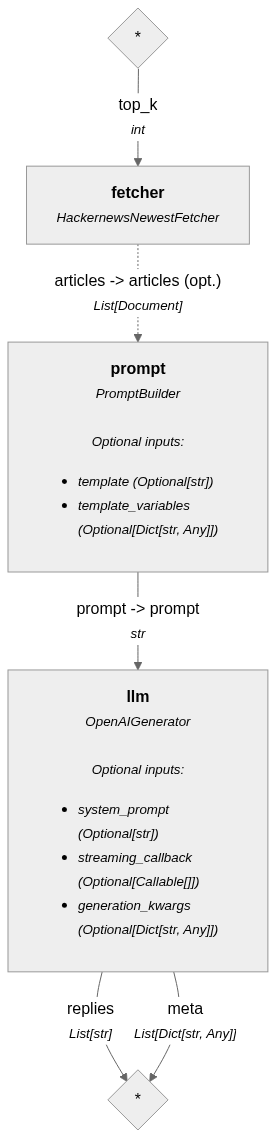

In [90]:
summarizer_pipeline.show()

In [92]:
import logging
from haystack import tracing
from haystack.tracing.logging_tracer import LoggingTracer

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

tracing.tracer.is_content_tracing_enabled = True # to enable tracing/logging content (inputs/outputs)
tracing.enable_tracing(LoggingTracer(tags_color_strings={"haystack.component.input": "\x1b[1;31m", "haystack.component.name": "\x1b[1;34m"}))

In [ ]:
import logging
import warnings

logging.getLogger("haystack").setLevel(logging.ERROR)
logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings('ignore')

In [98]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 2}})

print(summaries["llm"]["replies"][0])

INFO - haystack.core.pipeline.pipeline -  Running component fetcher


INFO - haystack.core.pipeline.pipeline -  Running component fetcher
DEBUG - haystack.tracing.logging_tracer -  Operation: haystack.component.run
DEBUG - haystack.tracing.logging_tracer -  haystack.component.name=fetcher
DEBUG - haystack.tracing.logging_tracer -  haystack.component.type=LinkContentFetcher
DEBUG - haystack.tracing.logging_tracer -  haystack.component.input_types={'urls': 'list'}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.input_spec={'urls': {'type': 'typing.List[str]', 'senders': []}}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.output_spec={'streams': {'type': 'typing.List[haystack.dataclasses.byte_stream.ByteStream]', 'receivers': ['converter']}}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.input={'urls': ['https://www.chemistryworld.com/opinion/benzene-at-200/4021504.article']}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.visits=1
DEBUG - haystack.tracing.logging_tracer -  haystack.component.output=

HackernewsNewestFetcher took 2.06 seconds
PromptBuilder took 0.00 seconds


DEBUG - haystack.tracing.logging_tracer -  Operation: haystack.component.run
DEBUG - haystack.tracing.logging_tracer -  haystack.component.name=llm
DEBUG - haystack.tracing.logging_tracer -  haystack.component.type=TimedComponent
DEBUG - haystack.tracing.logging_tracer -  haystack.component.input_types={'prompt': 'str', 'system_prompt': 'NoneType', 'streaming_callback': 'NoneType', 'generation_kwargs': 'NoneType'}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.input_spec={'prompt': {'type': 'str', 'senders': ['prompt']}, 'system_prompt': {'type': 'typing.Optional[str]', 'senders': []}, 'streaming_callback': {'type': 'typing.Optional[typing.Callable[[haystack.dataclasses.streaming_chunk.StreamingChunk], NoneType]]', 'senders': []}, 'generation_kwargs': {'type': 'typing.Optional[typing.Dict[str, typing.Any]]', 'senders': []}}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.output_spec={'replies': {'type': 'typing.List[str]', 'receivers': []}, 'meta': {'type':

OpenAIGenerator took 47.56 seconds
 8  - 1  to the short 

  4then molequelling to 
each ode3nall, then:
 









molec 
tarring

 10quinnally to 112
 to  

to 
  Osmilepropet tos
 a
   to-- -- -- to this 
  (oxelled �lost:sown to find 

  to one.dand to change, tollunntecrebection �original the nature of several compands and the earliest to 
 allgo-111agnostic to  --untiluntiltoughtwelliverenutilye until until Until until this


In [109]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews, followed by their URL.  
For each post, provide a brief summary followed by the URL the full post can be found at.  
  
Posts:  
{% for article in articles %}  
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}  
"""

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = MiniPHILLM()

wrapped_prompt_builder = TimedComponent(prompt_builder)
wrapped_fetcher = TimedComponent(fetcher)
wrapped_llm = TimedComponent(llm)

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

WARNING - haystack.components.builders.prompt_builder -  PromptBuilder has 1 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
DEBUG - haystack.core.pipeline.base -  Adding component 'fetcher' (<haystack.components.fetchers.link_content.LinkContentFetcher object at 0x71ac270190a0>

Inputs:
  - urls: List[str]
Outputs:
  - streams: List[ByteStream])
DEBUG - haystack.core.pipeline.base -  Adding component 'converter' (<haystack.components.converters.html.HTMLToDocument object at 0x71ac27019670>

Inputs:
  - sources: List[Union[str, Path, ByteStream]]
  - meta: Union[Dict[str, Any], List[Dict[str, Any]]]
  - extraction_kwargs: Optional[Dict[str, Any]]
Outputs:
  - documents: List[Document])
DEBUG - haystack.core.pipeline.base -  Connecting 'fet

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: MiniPHILLM
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [110]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 1}})

print(summaries["llm"]["replies"][0])

INFO - haystack.core.pipeline.pipeline -  Running component fetcher
INFO - haystack.core.pipeline.pipeline -  Running component fetcher
DEBUG - haystack.components.fetchers.link_content -  Switched user agent to haystack/LinkContentFetcher/2.13.2
DEBUG - haystack.tracing.logging_tracer -  Operation: haystack.component.run
DEBUG - haystack.tracing.logging_tracer -  haystack.component.name=fetcher
DEBUG - haystack.tracing.logging_tracer -  haystack.component.type=LinkContentFetcher
DEBUG - haystack.tracing.logging_tracer -  haystack.component.input_types={'urls': 'list'}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.input_spec={'urls': {'type': 'typing.List[str]', 'senders': []}}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.output_spec={'streams': {'type': 'typing.List[haystack.dataclasses.byte_stream.ByteStream]', 'receivers': ['converter']}}
DEBUG - haystack.tracing.logging_tracer -  haystack.component.input={'urls': ['https://www.chemistryworld.com/opi

 The article celebrates the bicentennial of benzene's discovery, a key molecule that has played an integral role in shaping chemistry and materials science over two centuries. Discovered by Michael Faraday in 1825 while studying illuminating gas residues, benzene exhibited unique properties such as high stability despite being highly unsaturated and emitting a sweet, intoxicating aroma. These intriguing qualities led to further exploration of its derivatives, namely polycyclic aromatic hydrocarbenas (PAHs) and the development of nanographenes, fullerenes, carbon nanotubes, and graphene – materials that have revolutionized various fields from electronics to medicine.

The Royal Society of Chemistry is commemorating this landmark anniversary with a special issue edited by Ben Feringa and Nazario Martín that highlights the influence of benzene on carbon-based systems. The article emphasizes how benzene's discovery has inspired generations of students and researchers to further understand 

### Extra resources! 

Learn more about the Haystack integrations:

* [deepset-ai github repo](https://github.com/deepset-ai/haystack-integrations)
* [haystack.deepset.ai/integrations](https://haystack.deepset.ai/integrations)